<a href="https://colab.research.google.com/github/mmm8sul/Clustering_sunspot_groups/blob/main/notebooks/Interpretation_of_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключаем необходимые библиотеки:

In [1]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.optim as optim
import torchvision.models as models

Загрузка датасета и распаковка:

In [ ]:
!wget https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
!unzip sunspot_dataset.zip

Клонируем репозиторий:

In [3]:
!git clone https://github.com/observethesun/helio.git

Cloning into 'helio'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 769 (delta 80), reused 127 (delta 69), pack-reused 607
Receiving objects: 100% (769/769), 6.80 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (405/405), done.


Устанавливаем необходимые пакеты из файла requirements.txt:

In [ ]:
%cd /content/helio
!pip install -r requirements.txt

Импортируем необходимы модули из библиотеки `helio` и определяем устройство на котором будет выполняться код:

In [5]:
from helio import FilesIndex, HelioBatch, BatchSampler
from helio import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Определяем модель вариационного автоэнкодера с использованием класса VAE из библиотеки helio. Модель VAE имеет входной канал 1, а уровни кодера и декодера имеют размеры фильтров [16, 24, 32, 64] и [48, 32, 24, 16] соответственно. Размерность скрытого пространства установлена равной 16. Выходной слой декодера имеет канал «c» и размер фильтра 1. Модель использует нормализацию.

In [6]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16],
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)

Для расчета потерь восприятия нам также понадобится предварительно обученная модель VGG11. Следуя рекомендациям к модели VGG11, определяем тензоры среднего и стандартного отклонения.

In [7]:
vgg = models.vgg11(pretrained=True)
dis = vgg.features.to(device)
vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 228MB/s]


Индексируем файлы в наборе данных изображений группы солнечных пятен и сортируем:

In [8]:
index = FilesIndex(path='/content/sunspot_dataset/*.npz', name='img').sort_index()
index

,img
FilesIndex,
201007230452_63,/content/sunspot_dataset/201007230452_63.npz
201007240414_63,/content/sunspot_dataset/201007240414_63.npz
201007250447_63,/content/sunspot_dataset/201007250447_63.npz
201007250447_64,/content/sunspot_dataset/201007250447_64.npz
201007260349_63,/content/sunspot_dataset/201007260349_63.npz
...,...
202008120532_31,/content/sunspot_dataset/202008120532_31.npz
202008120532_33,/content/sunspot_dataset/202008120532_33.npz
202008180351_34,/content/sunspot_dataset/202008180351_34.npz


Определяем функцию для преобразования 3-канальных бинарных масок в одноканальное изображение:

In [9]:
def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

Удаляем строки с выбросами:

In [10]:
ind_for_del = [13, 8158, 5670, 5863, 2064, 2068, 444, 10, 7495, 4237, 4598, 6705, 2724, 11, 831, 4737,\
               4230, 3593, 4266, 909, 370, 4712, 826, 3583, 10, 2715, 7475, 4226,\
               823, 2709, 7458, 4216, 3576, 4569, 6669, 4704, 4209, 821, 2704, 7439, 4554, 3569, 6651, 4199, 4688,\
               365, 893, 4217, 4640, 6898, 894, 1108,\
               6873, 6666, 5448, 1181, 6609, 4160, 1634, 1136, 2129, 4190, 2379, 2049, 2452, 359, 726, 5821, 6641,\
               2138, 4230, 4220, 2159, 5335, 1095, 2920, 6946, 7147, 6630, 5297, 6689, 2138, 1277, 904
               ]

Добавим новый столбец индексов:

In [11]:
num_index=list(range(0,index.shape[0]))
num_index[-1]
index['indx']=num_index
index.head()

,img,indx
FilesIndex,,
201007230452_63,/content/sunspot_dataset/201007230452_63.npz,0
201007240414_63,/content/sunspot_dataset/201007240414_63.npz,1
201007250447_63,/content/sunspot_dataset/201007250447_63.npz,2
201007250447_64,/content/sunspot_dataset/201007250447_64.npz,3
201007260349_63,/content/sunspot_dataset/201007260349_63.npz,4


Удаляем строки с выбросами:

In [12]:
index.drop(index[index['indx'].isin(ind_for_del)].index, inplace=True)

###Визуализируем группы солнечных пятен для разного числа кластеров

Число кластеров равно 4 (perplexity=5):

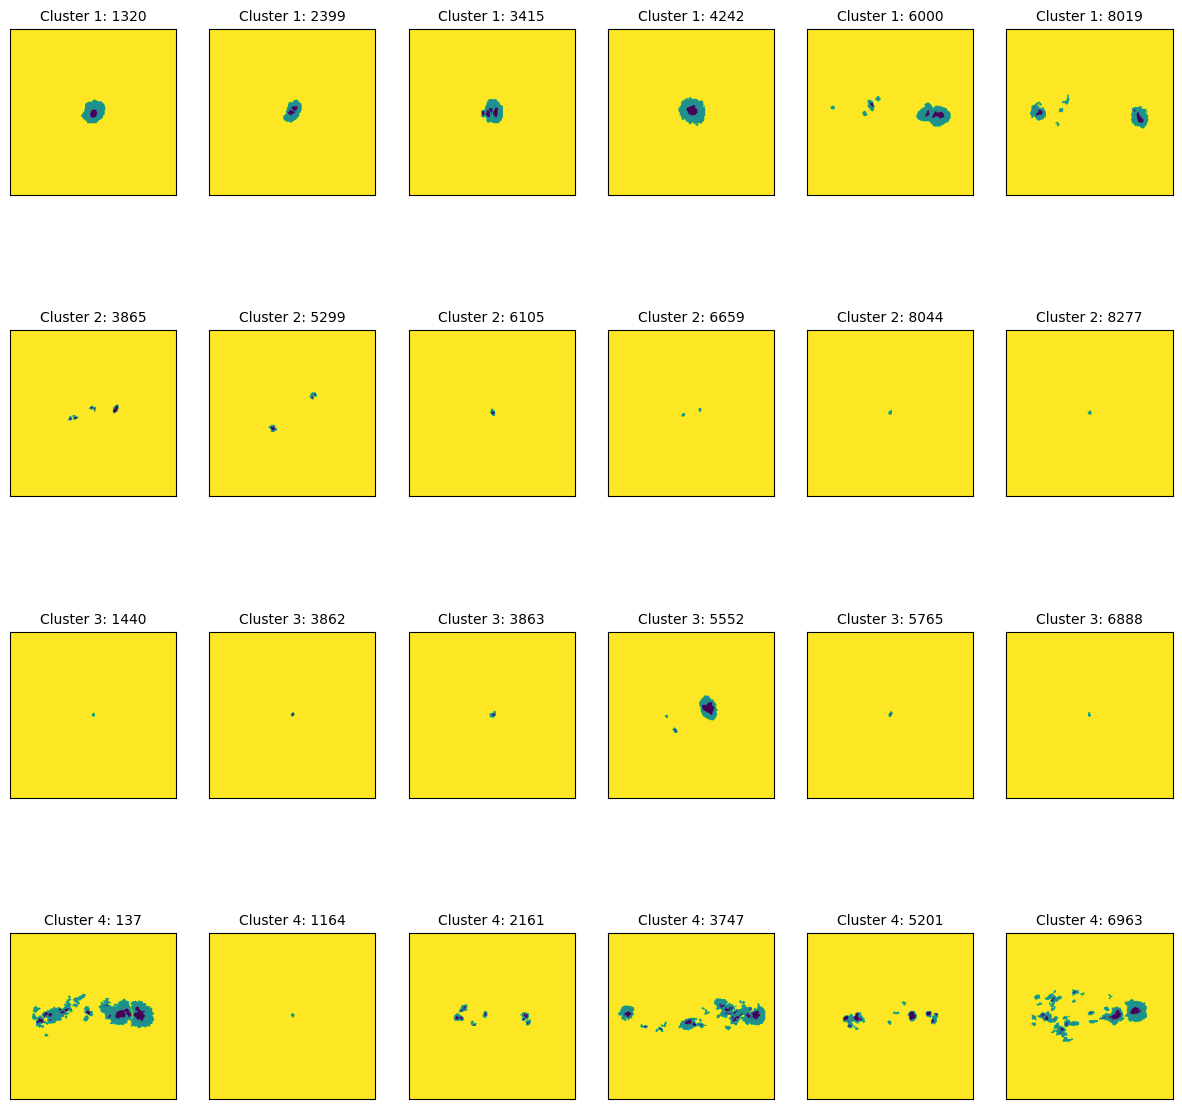

In [19]:
yellow_clust = [1320, 2399, 3415, 4242, 6000, 8019]
green_clust = [3865, 5299, 6105, 6659, 8044, 8277 ]
blue_clust = [1440, 3862, 3863, 5552, 5765, 6888]
purple_clust = [137, 1164, 2161, 3747, 5201, 6963]

net = net.eval()

fig, ax = plt.subplots(4, 6, figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, color_clust in enumerate([yellow_clust, green_clust, blue_clust, purple_clust]):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(6):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: {}'.format(i+1, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

Число кластеров равно 4 (perplexity=50):

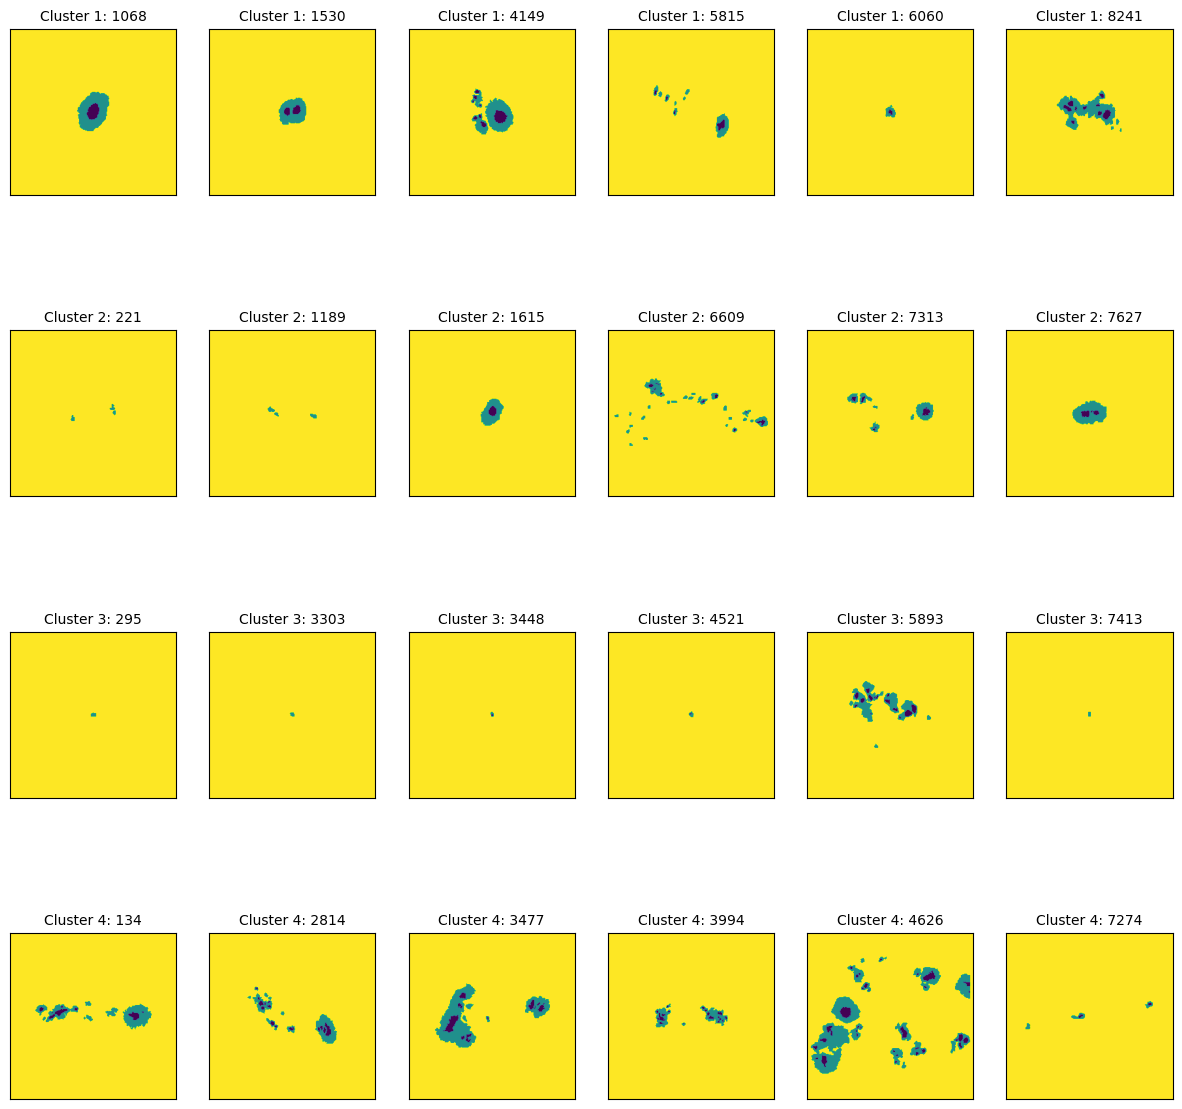

In [14]:
yellow_clust = [1068, 1530, 4149, 5815, 6060, 8241]
green_clust = [221, 1189, 1615, 6609, 7313, 7627]
blue_clust = [295, 3303, 3448, 4521, 5893, 7413]
purple_clust = [134, 2814, 3477, 3994, 4626, 7274]

net = net.eval()

fig, ax = plt.subplots(4, 6, figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, color_clust in enumerate([yellow_clust, green_clust, blue_clust, purple_clust]):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(6):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: {}'.format(i+1, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

Число кластеров равно 6 (perplexity=30):

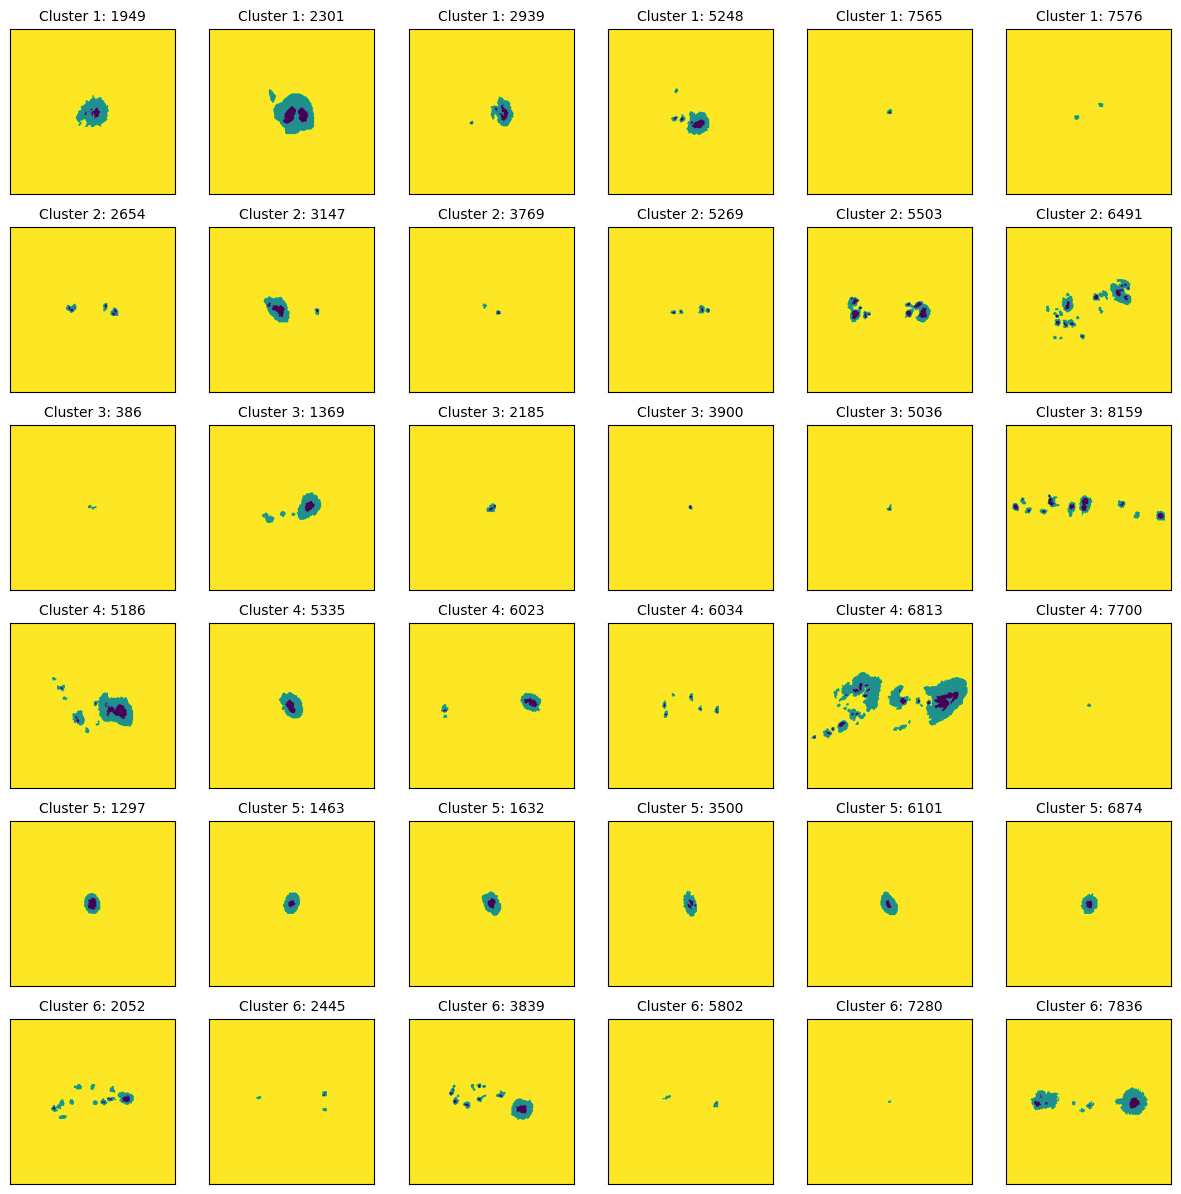

In [15]:
yellow_clust = [1949, 2301, 2939, 5248, 7565, 7576]
green_clust = [2654, 3147, 3769, 5269, 5503, 6491]
blue_clust = [386, 1369, 2185, 3900, 5036, 8159]
purple_clust = [5186, 5335, 6023, 6034, 6813, 7700]
light_green_clust = [1297, 1463, 1632, 3500, 6101, 6874]
dark_blue_clust = [2052, 2445, 3839, 5802, 7280, 7836]

net = net.eval()

fig, ax = plt.subplots(6, 6, figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, color_clust in enumerate([yellow_clust, green_clust, blue_clust, purple_clust, light_green_clust, dark_blue_clust]):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(6):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: {}'.format(i+1, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()

Число кластеров равно 6 (perplexity=40):

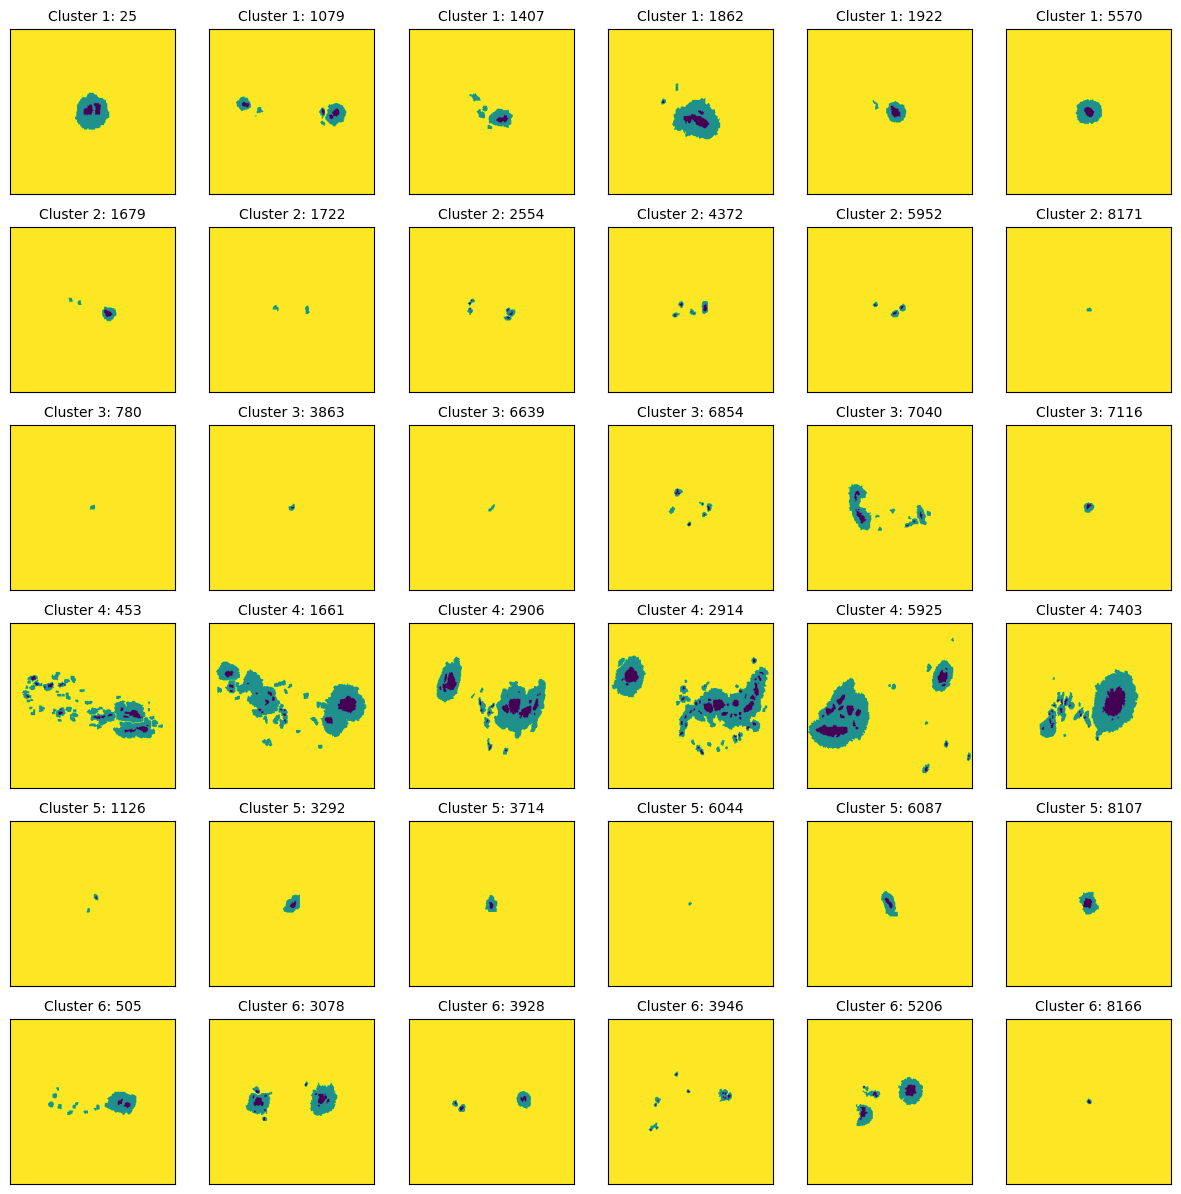

In [18]:
yellow_clust = [25, 1079, 1407, 1862, 1922, 5570]
green_clust = [1679, 1722, 2554, 4372, 5952, 8171]
blue_clust = [780, 3863, 6639, 6854, 7040, 7116]
purple_clust = [453, 1661, 2906, 2914, 5925, 7403]
light_green_clust = [1126, 3292, 3714, 6044, 6087, 8107]
dark_blue_clust = [505, 3078, 3928, 3946, 5206, 8166]

net = net.eval()

fig, ax = plt.subplots(6, 6, figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, color_clust in enumerate([yellow_clust, green_clust, blue_clust, purple_clust, light_green_clust, dark_blue_clust]):
    with torch.no_grad():
        batch = (HelioBatch(index.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(6):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: {}'.format(i+1, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

plt.show()